# Using a Deep Q-Network on a multi-stock portfolio

## Retrieving Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.fundamentaldata import FundamentalData
import numpy as np
import yfinance as yf

### Function to retrieve data

In [2]:
def retrieve_data(tickr):

    data = yf.download(tickr)
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data.columns = columns
    data = data.sort_index(ascending=True)
    data['Change Percentage'] = data['Close'].pct_change() * 100
    data['Force Index'] = data['Close'].diff() * data['Volume']
    
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    raw_money_flow = typical_price * data['Volume']
    money_flow_direction = typical_price.diff()
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    positive_mf = positive_flow.rolling(window=14, min_periods=0).sum()
    negative_mf = negative_flow.rolling(window=14, min_periods=0).sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        money_ratio = positive_mf / negative_mf
        data['Money Flow Index'] = 100 - (100 / (1 + money_ratio))
        data['Money Flow Index'].replace([np.inf], 100, inplace=True)

    data['Price-Volume'] = (data['Close'].pct_change() * data['Volume']).cumsum()
    data['Standard Deviation'] = data['Close'].rolling(window=20).std()
    return data

### Seperating test and train data

In [3]:
def split_data(data, start, end, test_start, test_end):
    train_data = data.loc[start : end]
    test_data = data.loc[test_start : test_end]
    return train_data, test_data

Creating close price dataframe

In [4]:
def retrieve_close(train_data, test_data):
    train_close = train_data['Close']
    test_close = test_data['Close']
    return train_close, test_close

### Normalising data

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def PCA_transform(train_data, test_data):
    # Scaling train data
    state_features = pd.DataFrame({
        'Volume': train_data['Volume'],
        'Change Percentage': train_data['Change Percentage'],
        'Force Index': train_data['Force Index'],
        'Money Flow Index': train_data['Money Flow Index'],
        'Price-Volume': train_data['Price-Volume'],
        'Standard Deviation': train_data['Standard Deviation']
    })
    scaler = MinMaxScaler() # Creating scaler object
    scaled_features_array = scaler.fit_transform(state_features)
    scaled_data = pd.DataFrame(scaled_features_array, columns=state_features.columns, index=state_features.index)

    # Train data PCA transform
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(scaled_data)

    # Scaling test data
    test_features = pd.DataFrame({
        'Volume': test_data['Volume'],
        'Change Percentage': test_data['Change Percentage'],
        'Force Index': test_data['Force Index'],
        'Money Flow Index': test_data['Money Flow Index'],
        'Price-Volume': test_data['Price-Volume'],
        'Standard Deviation': test_data['Standard Deviation']
    })
    scaled_test_features_array = scaler.transform(test_features) # Using ssame scaler object as train data
    scaled_test_data = pd.DataFrame(scaled_test_features_array, columns=test_features.columns)

    # PCA transform on test data
    X_test_pca = pca.transform(scaled_test_data)

    return X_train_pca, X_test_pca



### Creating multi-stock vector

In [6]:
asset_tickers = ['AAPL', 'TSLA', 'MSFT']

In [7]:
assets_close = []
def get_vector(asset_tickers):
    assets_train_close = []
    assets_test_close = []

    assets_train_pca = []
    assets_test_pca = []
    for i in asset_tickers:
        data = retrieve_data(i)
        data_train, data_test = split_data(data, '2015-01-01', '2019-12-31', '2020-01-01', '2020-12-31')
        
        data_train_close, data_test_close = retrieve_close(data_train, data_test)
        assets_train_close.append(data_train_close)
        assets_test_close.append(data_test_close)

        data_train_pca, data_test_pca = PCA_transform(data_train, data_test)
        assets_train_pca.append(data_train_pca)
        assets_test_pca.append(data_test_pca)

    return assets_train_close, assets_test_close, assets_train_pca, assets_test_pca
train_close, test_close, train_pca, test_pca = get_vector(asset_tickers)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_44157/229767503.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)
[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_44157/229767503.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace 

## Creating Deep Q Network

### Setting up environment

In [8]:
import itertools
import math
ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
STOCKS = ['STOCK_A', 'STOCK_B', "stock c"]

all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))

ACTIONS = [
    list(combo) for combo in all_possible_combos if sum(combo) <= 1.0
]

In [9]:
class environment:

    def __init__(self, price_data, PCA_data):
        self.data = price_data
        self.assets_pca = PCA_data
        self.cash_balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0,0] # Number of shares owned for each stock in portfolio
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []
        self.action_history = []
        self.weight_vector = [0,0,0]
        self.return_history = []


    #Action = [1,0,0]
    #Action = [-0.5,0.5,0]
    
        

    def step(self, action):

        stocks = self.data
        stock1 = stocks[0]
        trade = [] 
        if self.index <= len(stock1):
            data = self.data
            index = self.index
            old_net_worth = self.get_net_worth()
            total = self.get_net_worth()
            cash_balance = self.cash_balance
            trade.append(total)
            trade.append(action)
            cash_weight = 1
            for i in action:
                cash_weight -= i
                
            for i in range(len(action)):
                stock_data = self.data[i]
                

                current_weight = (self.num_shares[i] * stock_data.iloc[self.index]) / total
                
                trade.append(current_weight)
                trade.append(action)
                self.action_history.append(action[i])
                
                
                

                # Checking if action should buy or sell stock
                if action[i] > current_weight:

                    # Calculating cash amount to buy
                    to_buy = (action[i] - current_weight) * total

                    
                    

                    # Calculating new number of shares
                    new_shares = to_buy / stock_data.iloc[self.index]

                    # Adding new shares to total shares
                    self.num_shares[i] += new_shares

                    

                
                elif action[i] < current_weight:
                    to_sell = (current_weight - action[i]) * total
                    shares_to_sell = to_sell / stock_data.iloc[self.index]
                    new_num_shares = self.num_shares[i] - shares_to_sell
                    self.num_shares[i] = new_num_shares
                    
                        
            self.cash_balance = total * cash_weight
            self.balance_history.append(old_net_worth)



            
            annual_rate = 0.054
            # Daily risk-free rate
            daily_rate = annual_rate / 365
            self.cash_balance = self.cash_balance * (1+ daily_rate)
            trade.append(self.num_shares)
            trade.append(self.cash_balance)
            

            if self.index < (len(stock1)-1):
                self.index += 1
                volatility_window = 30 
    
        # Ensure we have enough historical data
                if self.index > volatility_window:
        # Get historical price data for all assets in the window
        # This assumes self.data is a list of pandas Series/DataFrames with prices
        # and they are aligned by index.
                    historical_data_window = [
                        asset.iloc[self.index - volatility_window : self.index] for asset in self.data
                    ]
        
        # Calculate daily returns for each asset in the window
                    asset_returns_window = [data.pct_change().dropna() for data in historical_data_window]
        
        # Combine into a single NumPy array (num_days x num_assets)
                    asset_returns_matrix = np.array(asset_returns_window).T
        
        # The 'action' is the new portfolio weight vector
        # Calculate the hypothetical returns of this new portfolio over the past window
                    projected_portfolio_returns = np.dot(asset_returns_matrix, action)
        
        # Calculate the standard deviation (volatility) of these projected returns
                    forward_looking_volatility = np.std(projected_portfolio_returns)
                else:
        # Not enough data yet to calculate volatility
                    forward_looking_volatility = 0.0

    # 3. Define the risk-adjusted reward
                risk_aversion_gamma = 0.5 # TUNE THIS HYPERPARAMETER
    
                
                
                new_net_worth = self.get_net_worth()
                
    
                # The reward is the change in value
                portfolio_return = (new_net_worth - old_net_worth) / old_net_worth
                self.return_history.append(portfolio_return)

                reward = portfolio_return - (risk_aversion_gamma * forward_looking_volatility)
                
                self.trades.append(trade)
                self.total_reward += reward
                self.rewards.append(self.total_reward)
                self.weight_vector = action
        
            else:
                self.index += 1
                reward = 0
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.cash_balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0,0]
        self.trend = None
        self.balance_history = []
        self.trades = []
        self.weight_vector = [0,0,0]
        self.return_history = []
    
    def get_net_worth(self):
        data = self.data
        total = 0
        num_shares = self.num_shares
        for i in range(len(num_shares)):
            price_data = data[i]
            total += num_shares[i] * price_data.iloc[self.index]
        total += self.cash_balance
        return total
        
    def get_state(self):
        state = []
        
        for i in range(len(self.assets_pca)):
            stock_pca = self.assets_pca[i]
            

            current_pca = stock_pca[self.index]
          
            for i in current_pca:
                state.append(i)
        return state


### Training the model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import itertools
import math

# Create the Stock Environment
def train_model(env):
    
    
    # Neural network model for approximating Q-values
    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.fc2 = nn.Linear(128, 128)
            self.fc3 = nn.Linear(128, output_dim)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            return self.fc3(x)
    
    # Hyperparameters
    learning_rate = 0.001
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    batch_size = 64
    target_update_freq = 1000
    memory_size = 10000
    episodes = 50
    
    ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    STOCKS = ['STOCK_A', 'STOCK_B', 'Stock c']
    
    all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))
    
    ACTIONS = [
        list(combo) for combo in all_possible_combos if sum(combo) <= 1.0
    ]
    
    # Initialize Q-networks
    input_dim = 13
    output_dim = 286
    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = deque(maxlen=memory_size)
    
    # Function to choose action using epsilon-greedy policy
    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, len(ACTIONS) - 1)  # Explore
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state)
            return torch.argmax(q_values).item()
            
    
    # Function to optimize the model using experience replay
    def optimize_model():
        if len(memory) < batch_size:
            return
        
        batch = random.sample(memory, batch_size)
    
        state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)
        state_batch = torch.FloatTensor(np.array(state_batch, dtype=np.float32))
    
        state_batch = torch.FloatTensor(state_batch)
        
     
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch)
        next_state_batch = torch.FloatTensor(next_state_batch)
        
    
        # Compute Q-values for current states
    
        # Now the gather operation will work
        q_values = policy_net(state_batch).gather(1, action_batch).squeeze()
    
        # Compute target Q-values using the target network
        with torch.no_grad():
            max_next_q_values = target_net(next_state_batch).max(1)[0]
            target_q_values = reward_batch + gamma * max_next_q_values
    
        loss = nn.MSELoss()(q_values, target_q_values)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Main training loop
    steps_done = 0
    
    for episode in range(episodes):
        state = env.get_state()
        done = False
        i = 0
        for i in range(len(train_close[i])-1):
            # Select action
            action_index = select_action(state, epsilon)
           
            action = ACTIONS[action_index]
            reward, done = env.step(action)
            
            next_state = env.get_state()
            # Store transition in memory
            memory.append((state, action_index, reward, next_state))
            
            # Update state
            state = next_state
    
            # Optimize model
            optimize_model()
            steps_done += 1
    
            # Update target network periodically
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
    
    
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        env.reset()
    return policy_net

## Testing

In [11]:
def test(env, policy_net):
    
    # Reset the environment
    env.reset()  

    step = 0
    done = False
    action_history = []
    sum = 0
    stock1 = test_close[0]
    
    while env.index < (len(stock1)):
   
        state = env.get_state()
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]
       

        env.step(action)
        sum += 1
        
     

        if done:
            break
   

In [12]:
returns = []
for i in range(1):
    env = environment(train_close, train_pca)
    policy_net = train_model(env)
    test_env = environment(test_close, test_pca)
    test(test_env, policy_net)
    returns.append((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])
    print(i)    

0


In [13]:
total = 0
for i in returns:
    total += i
avg = total/len(returns)
print(avg)
print(returns)

1.8119919314616493
[1.8119919314616493]


In [15]:
daily_std = np.std(test_env.return_history)
annual_std = daily_std * np.sqrt(252)
sharpe_ratio = avg / annual_std

print(annual_std)
print(sharpe_ratio)

0.4753320527219235
3.8120550067800543


In [16]:
aapl = test_close[0]
tsla = test_close[1]
msft = test_close[2]
totalr = 0
for i in test_close:
    r = (i[-1] - i[0]) / i[0]
    r = r * 0.33333
    totalr += r
print(totalr)

2.8273048211404066


/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_44157/1061797784.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r = (i[-1] - i[0]) / i[0]


### Plotting model performace against underlying stock price

In [17]:
df1 = pd.DataFrame(test_close[0])
df1.columns = ['Close']
df1['Model_Balance'] = test_env.balance_history
print(df1)

                 Close  Model_Balance
Date                                 
2020-01-02   71.627069     100.000000
2020-01-03   71.847133     100.881434
2020-01-06   71.034709     100.233664
2020-01-07   72.497529     102.996423
2020-01-08   71.849540     103.063097
...                ...            ...
2020-12-24  128.102884     271.415661
2020-12-28  130.707502     278.966183
2020-12-29  134.668006     278.118242
2020-12-30  132.258541     279.173204
2020-12-31  130.795293     281.199193

[253 rows x 2 columns]


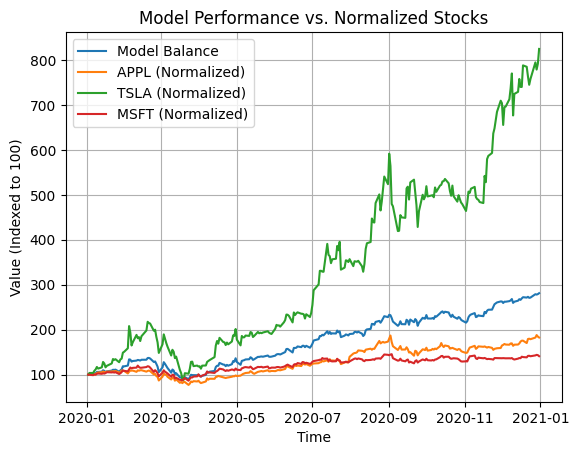

In [18]:
appl_scaled = (test_close[0] / test_close[0].iloc[0]) * 100
tsla_scaled = (test_close[1] / test_close[1].iloc[0]) * 100
msft_scaled = (test_close[2] / test_close[2].iloc[0]) * 100

# Plot the data
plt.plot(df1['Model_Balance'], label="Model Balance")
plt.plot(appl_scaled, label="APPL (Normalized)")
plt.plot(tsla_scaled, label="TSLA (Normalized)")
plt.plot(msft_scaled, label="MSFT (Normalized)")

plt.title("Model Performance vs. Normalized Stocks")
plt.xlabel("Time")
plt.ylabel("Value (Indexed to 100)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
equal_weight_df = pd.DataFrame({
    'Stock0': test_close[0],
    'Stock1': test_close[1],
    'Stock2': test_close[2]
})

# 2. Calculate the daily percentage returns for each stock
daily_asset_returns = equal_weight_df.pct_change().dropna()

# 3. Define the equal weights for the portfolio
# In this case, 1/3 for each of the three stocks.
weights = np.array([1/3, 1/3, 1/3])

# 4. Calculate the daily returns of the equally weighted portfolio
# This is the dot product of the asset returns and their weights.
equal_weight_returns = np.dot(daily_asset_returns, weights)

In [20]:
baseline_day_std = np.std(equal_weight_returns)
baseline_year_std = baseline_day_std * np.sqrt(252)
baseline_sharpe = totalr / baseline_year_std
print(baseline_sharpe)

5.402886813704781
